In [1]:
from pyspark.sql.functions import *

from pyspark.sql import SparkSession, functions as F, types as T
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [2]:

spark_session = SparkSession.builder \
    .appName('test') \
    .getOrCreate()


In [3]:
data = spark.sql('SELECT * FROM heart_data')

In [4]:
data.show(5, truncate=False)

+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+
age|sex|chest_pain_type|resting_blood_pressure|cholesterol|fasting_blood_sugar|resting_ecg|max_heart_rate|exercise_angina|exercise_ST_depression|ST_peak_slope|fluoroscopy_number_vessels|thal|target|
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+
63 |1 |3 |145 |233 |1 |0 |150 |0 |2.3 |0 |0 |1 |1 |
37 |1 |2 |130 |250 |0 |1 |187 |0 |3.5 |0 |0 |2 |1 |
41 |0 |1 |130 |204 |0 |0 |172 |0 |1.4 |2 |0 |2 |1 |
56 |1 |1 |120 |236 |0 |1 |178 |0 |0.8 |2 |0 |2 |1 |
57 |0 |0 |120 |354 |0 |1 |163 |1 |0.6 |2 |0 |2 |1 |
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+
only showing top 5 rows

In [5]:
data.describe().show()

+-------+------------------+-------------------+------------------+----------------------+------------------+-------------------+-----------------+------------------+-------------------+----------------------+------------------+--------------------------+------------------+------------------+
summary| age| sex| chest_pain_type|resting_blood_pressure| cholesterol|fasting_blood_sugar| resting_ecg| max_heart_rate| exercise_angina|exercise_ST_depression| ST_peak_slope|fluoroscopy_number_vessels| thal| target|
+-------+------------------+-------------------+------------------+----------------------+------------------+-------------------+-----------------+------------------+-------------------+----------------------+------------------+--------------------------+------------------+------------------+
 count| 303| 303| 303| 303| 303| 303| 303| 303| 303| 303| 303| 303| 303| 303|
 mean|54.366336633663366| 0.6831683168316832| 0.966996699669967| 131.62376237623764|246.26402640264027| 0.1485148514851485|0.528052805280528|149.64686468646866|0.32673267326732675| 1.0396039603960396|1.3993399339933994| 0.7293729372937293|2.3135313531353137|0.5445544554455446|
 stddev| 9.08210098983786|0.46601082333962385|1.0320524894832983| 17.5381428135171| 51.83075098793005|0.35619787492797644|0.525859596359298| 22.90516111491409|0.46979446452231655| 1.1610750220686346|0.6162261453459622| 1.0226063649693276|0.6122765072781408|0.4988347841643915|
 min| 29| 0| 0| 94| 126| 0| 0| 71| 0| 0.0| 0| 0| 0| 0|
 max| 77| 1| 3| 200| 564| 1| 2| 202| 1| 6.2| 2| 4| 3| 1|
+-------+------------------+-------------------+------------------+----------------------+------------------+-------------------+-----------------+------------------+-------------------+----------------------+------------------+--------------------------+------------------+------------------+

Check for null or NaN values

In [7]:
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+
age|sex|chest_pain_type|resting_blood_pressure|cholesterol|fasting_blood_sugar|resting_ecg|max_heart_rate|exercise_angina|exercise_ST_depression|ST_peak_slope|fluoroscopy_number_vessels|thal|target|
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+

Age Distribution

In [9]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Gender Distribution, 1 is male

In [11]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Chest Pain Type

In [13]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Chest pain type according to resting ecg type

In [15]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Resting Blood Pressure Distribution

In [17]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Cholesterol Distribution

In [19]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Fasting Blood Sugar

In [21]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Rest electrocardiographical Results

In [23]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Maximum Heart Rate

In [25]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Presence of Exercise Induced Angina

In [27]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


ST depression induced by exercise relative to rest

In [29]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Number of major vessels colored by flourosopy

In [31]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Presence of Heart Disease according to gender

In [33]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Average max heart rate according to age

In [35]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Presence of heart disease when heart angina is present according to gender

In [37]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Presence of heart disease according to exercised induced ST depression, grouped by gender

In [39]:
display(data)

age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [40]:
from pyspark.mllib.stat import Statistics
import pandas as pd


def compute_correlation_matrix(df, method='pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

In [41]:
correlation_matrix = compute_correlation_matrix(data)

Data correlation matrix

In [43]:
correlation_matrix.show

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,exercise_ST_depression,ST_peak_slope,fluoroscopy_number_vessels,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
chest_pain_type,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
resting_blood_pressure,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
cholesterol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fasting_blood_sugar,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
resting_ecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
max_heart_rate,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exercise_angina,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
exercise_ST_depression,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


Data correlation heatmap

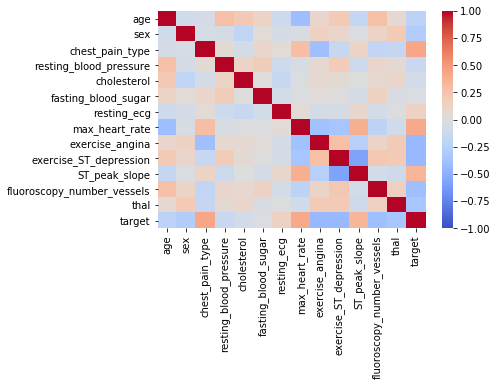

In [45]:
pandas_df = data.toPandas()
sns.heatmap(pandas_df.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [46]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer 
feature_columns = data.drop('target').columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')	

Data assembly

In [48]:
assembled_data = assembler.transform(data)

In [49]:
assembled_data.show()

+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+--------------------+
age|sex|chest_pain_type|resting_blood_pressure|cholesterol|fasting_blood_sugar|resting_ecg|max_heart_rate|exercise_angina|exercise_ST_depression|ST_peak_slope|fluoroscopy_number_vessels|thal|target| features|
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+--------------------+
 63| 1| 3| 145| 233| 1| 0| 150| 0| 2.3| 0| 0| 1| 1|[63.0,1.0,3.0,145...|
 37| 1| 2| 130| 250| 0| 1| 187| 0| 3.5| 0| 0| 2| 1|[37.0,1.0,2.0,130...|
 41| 0| 1| 130| 204| 0| 0| 172| 0| 1.4| 2| 0| 2| 1|[41.0,0.0,1.0,130...|
 56| 1| 1| 120| 236| 0| 1| 178| 0| 0.8| 2| 0| 2| 1|[56.0,1.0,1.0,120...|
 57| 0| 0| 120| 354| 0| 1| 163| 1| 0.6| 2| 0| 2| 1|[57.0,0.0,0.0,120...|
 57| 1| 0| 140| 192| 0| 1| 148| 0| 0.4| 1| 0| 1| 1|[57.0,1.0,0.0,140...|
 56| 0| 1| 140| 294| 0| 0| 153| 0| 1.3| 1| 0| 2| 1|[56.0,0.0,1.0,140...|
 44| 1| 1| 120| 263| 0| 1| 173| 0| 0.0| 2| 0| 3| 1|[44.0,1.0,1.0,120...|
 52| 1| 2| 172| 199| 1| 1| 162| 0| 0.5| 2| 0| 3| 1|[52.0,1.0,2.0,172...|
 57| 1| 2| 150| 168| 0| 1| 174| 0| 1.6| 2| 0| 2| 1|[57.0,1.0,2.0,150...|
 54| 1| 0| 140| 239| 0| 1| 160| 0| 1.2| 2| 0| 2| 1|[54.0,1.0,0.0,140...|
 48| 0| 2| 130| 275| 0| 1| 139| 0| 0.2| 2| 0| 2| 1|[48.0,0.0,2.0,130...|
 49| 1| 1| 130| 266| 0| 1| 171| 0| 0.6| 2| 0| 2| 1|[49.0,1.0,1.0,130...|
 64| 1| 3| 110| 211| 0| 0| 144| 1| 1.8| 1| 0| 2| 1|[64.0,1.0,3.0,110...|
 58| 0| 3| 150| 283| 1| 0| 162| 0| 1.0| 2| 0| 2| 1|[58.0,0.0,3.0,150...|
 50| 0| 2| 120| 219| 0| 1| 158| 0| 1.6| 1| 0| 2| 1|[50.0,0.0,2.0,120...|
 58| 0| 2| 120| 340| 0| 1| 172| 0| 0.0| 2| 0| 2| 1|[58.0,0.0,2.0,120...|
 66| 0| 3| 150| 226| 0| 1| 114| 0| 2.6| 0| 0| 2| 1|[66.0,0.0,3.0,150...|
 43| 1| 0| 150| 247| 0| 1| 171| 0| 1.5| 2| 0| 2| 1|[43.0,1.0,0.0,150...|
 69| 0| 3| 140| 239| 0| 1| 151| 0| 1.8| 2| 2| 2| 1|[69.0,0.0,3.0,140...|
+---+---+---------------+----------------------+-----------+-------------------+-----------+--------------+---------------+----------------------+-------------+--------------------------+----+------+--------------------+
only showing top 20 rows

In [50]:
final_data = assembled_data.select('features', 'target')

Train-Test splitting the data

In [52]:
train_data, test_data = final_data.randomSplit([0.7, 0.3])

Decision Tree Classifier and its representation

In [54]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline


dtc = DecisionTreeClassifier().setLabelCol("target")

dtc_model = dtc.fit(train_data)
display(dtc_model)

treeNode
"{""index"":15,""featureType"":""continuous"",""prediction"":null,""threshold"":0.75,""categories"":null,""feature"":9,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":2,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":11,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":41.5,""categories"":null,""feature"":0,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":13,""featureType"":""continuous"",""prediction"":null,""threshold"":332.5,""categories"":null,""feature"":4,""overflow"":false}"


In [55]:
dtc_preds = dtc_model.transform(test_data)

In [56]:
dtc_preds.show()

+--------------------+------+-------------+--------------------+----------+
 features|target|rawPrediction| probability|prediction|
+--------------------+------+-------------+--------------------+----------+
(13,[0,3,4,7,8,10...| 1| [3.0,20.0]|[0.13043478260869...| 1.0|
(13,[0,3,4,7,9,11...| 0| [9.0,1.0]| [0.9,0.1]| 0.0|
[35.0,1.0,1.0,122...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[37.0,1.0,2.0,130...| 1| [1.0,15.0]| [0.0625,0.9375]| 1.0|
[38.0,1.0,2.0,138...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[38.0,1.0,3.0,120...| 0| [1.0,15.0]| [0.0625,0.9375]| 1.0|
[39.0,1.0,0.0,118...| 0| [0.0,6.0]| [0.0,1.0]| 1.0|
[41.0,0.0,1.0,130...| 1| [1.0,15.0]| [0.0625,0.9375]| 1.0|
[41.0,1.0,2.0,112...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[41.0,1.0,2.0,130...| 1| [1.0,15.0]| [0.0625,0.9375]| 1.0|
[42.0,0.0,2.0,120...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[42.0,1.0,1.0,120...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[42.0,1.0,2.0,120...| 1| [1.0,15.0]| [0.0625,0.9375]| 1.0|
[43.0,0.0,0.0,132...| 0| [38.0,0.0]| [1.0,0.0]| 0.0|
[43.0,1.0,0.0,110...| 1| [3.0,20.0]|[0.13043478260869...| 1.0|
[43.0,1.0,0.0,120...| 0| [38.0,0.0]| [1.0,0.0]| 0.0|
[43.0,1.0,0.0,132...| 0| [8.0,1.0]|[0.88888888888888...| 0.0|
[44.0,0.0,2.0,108...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
[44.0,1.0,0.0,112...| 0| [8.0,1.0]|[0.88888888888888...| 0.0|
[44.0,1.0,2.0,130...| 1| [4.0,60.0]| [0.0625,0.9375]| 1.0|
+--------------------+------+-------------+--------------------+----------+
only showing top 20 rows

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,   MulticlassClassificationEvaluator

In [58]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName='areaUnderROC')


In [59]:
dt_acc = evaluatorMulti.evaluate(dtc_preds, {evaluatorMulti.metricName: "accuracy"})
dt_f1 = evaluatorMulti.evaluate(dtc_preds, {evaluatorMulti.metricName: "f1"})
dt_weightedPrecision = evaluatorMulti.evaluate(dtc_preds, {evaluatorMulti.metricName: "weightedPrecision"})
dt_weightedRecall = evaluatorMulti.evaluate(dtc_preds, {evaluatorMulti.metricName: "weightedRecall"})
dt_auc = evaluator.evaluate(dtc_preds)

Decision Tree Evaluatiion Metrics

In [61]:
print('Decision Tree Accurary: ', dt_acc)
print('Decision Tree F1 Score: ', dt_f1)
print('Decision Tree Precision: ', dt_weightedPrecision)
print('Decision Tree Recall: ', dt_weightedRecall)
print('Decision Tree AUC: ', dt_auc)

Decision Tree Accurary: 0.7204301075268817
Decision Tree F1 Score: 0.7204301075268817
Decision Tree Precision: 0.7204301075268817
Decision Tree Recall: 0.7204301075268817
Decision Tree AUC: 0.7203977798334874

In [62]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="target", featuresCol="features", numTrees=50)

rf_model = rf.fit(train_data)
rf_preds = rf_model.transform(test_data)

In [63]:
rf_acc = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "accuracy"})
rf_f1 = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "f1"})
rf_weightedPrecision = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "weightedPrecision"})
rf_weightedRecall = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "weightedRecall"})
rf_auc = evaluator.evaluate(rf_preds)

Random Forest Evaluation Metrics

In [65]:
print('Random Forest Accurary: ', rf_acc)
print('Random Forest F1 Score: ', rf_f1)
print('Random Forest Precision: ', rf_weightedPrecision)
print('Random Forest Recall: ', rf_weightedRecall)
print('Random Forest AUC: ', rf_auc)

Random Forest Accurary: 0.8387096774193549
Random Forest F1 Score: 0.8373569804798315
Random Forest Precision: 0.8521839790091064
Random Forest Recall: 0.8387096774193548
Random Forest AUC: 0.8397317298797411

In [66]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="target", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_preds = gbt_model.transform(test_data)

In [67]:
gbt_acc = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "accuracy"})
gbt_f1 = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "f1"})
gbt_weightedPrecision = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "weightedPrecision"})
gbt_weightedRecall = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "weightedRecall"})
gbt_auc = evaluator.evaluate(gbt_preds)

Gradient Boosted Trees Evaluation Metrics

In [69]:
print('Gradient Boosted Trees Accurary: ', gbt_acc)
print('Gradient Boosted Trees F1 Score: ', gbt_f1)
print('Gradient Boosted Trees Precision: ', gbt_weightedPrecision)
print('Gradient Boosted Trees Recall: ', gbt_weightedRecall)
print('Gradient Boosted Trees AUC: ', gbt_auc)

Gradient Boosted Trees Accurary: 0.7419354838709677
Gradient Boosted Trees F1 Score: 0.7392247221469233
Gradient Boosted Trees Precision: 0.7542346493959398
Gradient Boosted Trees Recall: 0.7419354838709677
Gradient Boosted Trees AUC: 0.7430619796484736

In [70]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol='target')
nb_model = nb.fit(train_data)
nb_preds = nb_model.transform(test_data)

In [71]:
nb_acc = evaluatorMulti.evaluate(nb_preds, {evaluatorMulti.metricName: "accuracy"})
nb_f1 = evaluatorMulti.evaluate(nb_preds, {evaluatorMulti.metricName: "f1"})
nb_weightedPrecision = evaluatorMulti.evaluate(nb_preds, {evaluatorMulti.metricName: "weightedPrecision"})
nb_weightedRecall = evaluatorMulti.evaluate(nb_preds, {evaluatorMulti.metricName: "weightedRecall"})
nb_auc = evaluator.evaluate(nb_preds)

Naive Bayes Evalutation Metrics

In [73]:
print('Naive Bayes Accurary: ', nb_acc)
print('Naive Bayes F1 Score: ', nb_f1)
print('Naive Bayes Precision: ', nb_weightedPrecision)
print('Naive Bayes Recall: ', nb_weightedRecall)
print('Naive Bayes AUC: ', nb_auc)

Naive Bayes Accurary: 0.7634408602150538
Naive Bayes F1 Score: 0.7619004751187797
Naive Bayes Precision: 0.7718959654443525
Naive Bayes Recall: 0.7634408602150538
Naive Bayes AUC: 0.7643385753931544

In [74]:
metrics = spark.createDataFrame(
  [(dt_acc, dt_f1, dt_weightedPrecision, dt_weightedRecall, dt_auc),
  (rf_acc, rf_f1, rf_weightedPrecision, rf_weightedRecall, rf_auc),
  (gbt_acc, gbt_f1, gbt_weightedPrecision, gbt_weightedRecall, gbt_auc),
  (nb_acc, nb_f1, nb_weightedPrecision, nb_weightedRecall, nb_auc)],
  ['Accuracy', 'F1-Score', 'Precision',  'Recall', 'AUC']
)

Comparison of model metrics, id 0 is DT, 1 is RF, 2 is GBT and 3 is NB

In [76]:
display(metrics)

Accuracy,F1-Score,Precision,Recall,AUC
0.7204301075268817,0.7204301075268817,0.7204301075268817,0.7204301075268817,0.7203977798334874
0.8387096774193549,0.8373569804798315,0.8521839790091064,0.8387096774193548,0.8397317298797411
0.7419354838709677,0.7392247221469233,0.7542346493959398,0.7419354838709677,0.7430619796484736
0.7634408602150538,0.7619004751187797,0.7718959654443525,0.7634408602150538,0.7643385753931544
